In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def split_matrix(matrix, parts):
    '''Genearating submatrices'''
    assert parts <= matrix.shape[1]
    
    return np.split(matrix, parts, axis=1)


def encode_poly_matrix(matrix_parts, N, power=1):
    x = np.arange(1, N + 1)
    parts = len(matrix_parts)

    matrix_tilda = [sum(matrix_parts[j] * xi**(j*power) for j in range(parts)) for xi in x]

    return matrix_tilda


def stragle_random_part(A_tilda, B_tilda, straglers=0, seed=None):
    if straglers == 0:
        return A_tilda, B_tilda, np.arange(len(A_tilda))

    assert len(A_tilda) == len(B_tilda)
    np.random.seed(seed)
    N = len(A_tilda)

    saved_nodes = np.random.choice(range(N), size=N-straglers, replace=False)
    saved_nodes = sorted(saved_nodes)

    A_tilda = [A_tilda[i] for i in saved_nodes]
    B_tilda = [B_tilda[i] for i in saved_nodes]

    return A_tilda, B_tilda, np.array(saved_nodes)


def recovery_matrix_poly(C_tilda, N, K, saved_nodes, l, p, m):    
    vander = np.vander(np.arange(1, N + 1), K, increasing=True).astype(np.float64)
    vander_pinv = np.linalg.pinv(vander[saved_nodes])

    C_tilda_reshaped = np.hstack([C_tilda[i::l] for i in range(l)])
    C_rec_reshaped = vander_pinv @ C_tilda_reshaped

    C_rec = np.vstack([C_i.reshape(l, p) for C_i in C_rec_reshaped])
    C_rec = np.hstack(np.split(C_rec, m))

    return C_rec

In [3]:
RANDOM_STATE = None

In [4]:
m, n = 7, 7
bound = 1

N = 10
K = m * n 

#Input matrix size - A: s by r, B: s by t
s = 21
r = 49 * 4
t = 49 * 4
l = r // m
p = t // n

## Polynomial code

In [38]:
def poly_experiment(m, n, N, A, B, r, t, straglers=0, verbose=False):
#     A = np.random.rand(s, r)
#     B = np.random.rand(s, t)
    C = A.T @ B

    if verbose:
        print('A, B, C:', end='\n\n')
        print(A, B, C, sep='\n\n')

    A_parts = split_matrix(A, m)
    B_parts = split_matrix(B, n)
    l, p = r // m, t // n

    A_tilda = encode_poly_matrix(A_parts, N, 1)
    B_tilda = encode_poly_matrix(B_parts, N, m)

    A_tilda, B_tilda, saved_nodes = stragle_random_part(A_tilda, B_tilda, straglers, seed=RANDOM_STATE)

    C_tilda = [A_ti.T @ B_ti for A_ti, B_ti in zip(A_tilda, B_tilda)]
    C_tilda = np.vstack(C_tilda)

    C_rec = recovery_matrix_poly(C_tilda, N, m*n, saved_nodes, l, p, m)

    if verbose:
        print('\nC_rec, C:', end='\n\n')
        print(C_rec, C, sep='\n\n')

    nmse = np.linalg.norm(abs(C - C_rec))/np.linalg.norm(C)
    return nmse

In [6]:
print('NMSE:', poly_experiment(7, 7, 50, 49 * 4, 49 * 4, straglers=0, verbose=False))

NMSE: 8.962111825216544e+20


## Cond of Vandermonde matrix

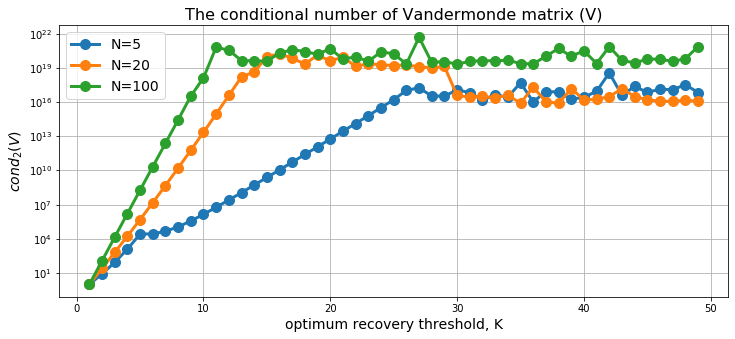

In [8]:
def calculate_cond_vander(N, grid):
    cond_vander = []
    alphas = np.arange(1, N+1)
    for m in grid:
        vand = np.vander(alphas, m, increasing=True) #Size of the Vandermonde matrix
        cond_vander.append(np.linalg.cond(vand))   
    
    return cond_vander


rec_thr = np.arange(1, 50)
cond_vander = {}

Ns = [5, 20, 100]
cond_vander = {n: calculate_cond_vander(n, grid) for n in Ns}
    

plt.figure(figsize=((12, 5)))
plt.grid() 

for N in Ns:
    plt.plot(rec_thr, cond_vander[N],  marker='o', lw=3, markersize=10, label=f'N={N}')

plt.xlabel("optimum recovery threshold, K", fontsize=14)
plt.ylabel("$cond_2(V)$", fontsize=14)
plt.yscale("log")
plt.title("The conditional number of Vandermonde matrix (V)", fontsize=16)
plt.legend(loc='best', fontsize=14)
# plt.savefig("graph_cond_of_vander")

## Average relative errror

## Orthopolynomial. Chebyshev

In [9]:
import numpy.polynomial.chebyshev as cheb

In [10]:
def T(idx=0):
    coefs = np.zeros(idx+1)
    coefs[idx] = 1
    
    #if idx == 0:
        #return lambda x: cheb.Chebyshev(coefs)(x) / np.sqrt(2)
    return cheb.Chebyshev(coefs)


def generate_matrix_H(m, n):
    def generate_submatrix_H(m):
        H_i = np.zeros((2*m - 1, m))
        diagonal_part = np.diag(np.ones(m-1)/2)
        H_i[m-1, 0] = 1
        H_i[-m+1:, -m+1:] = diagonal_part
        H_i[:m-1, -m+1:] = np.rot90(diagonal_part)

        return H_i

    H = np.zeros((m*n, m*n)) 
    H_i = generate_submatrix_H(m)
    
    H[:m, :m] = np.eye(m)
    
    for i in range(1, n):
        H[m*(i-1) + 1: m*(i+1), i*m : (i+1)*m] = H_i

    return H


def encode_cheb_matrix(matrix_parts, N, m, x):
    parts = len(matrix_parts)
    matrix_tilda = [sum(matrix_parts[j] * T(j*m)(xi) for j in range(parts)) for xi in x]

    return matrix_tilda


def recovery_matrix_cheb(C_tilda, m, n, saved_nodes, x, l, p):    
    chebvander = cheb.chebvander(x, m*n - 1).astype(np.float64)
    #chebvander[:, 0] /= np.sqrt(2)

    H = generate_matrix_H(m, n)

    #print((chebvander @ H).shape)
    chebvander_pinv = np.linalg.pinv((chebvander @ H) [saved_nodes])

    C_tilda_reshaped = np.hstack([C_tilda[i::l] for i in range(l)])
    C_rec_reshaped = chebvander_pinv @ C_tilda_reshaped

    C_rec = np.vstack([C_i.reshape(l, p) for C_i in C_rec_reshaped])
    C_rec = np.hstack(np.split(C_rec, m))

    return C_rec

In [11]:
m, n = 2, 2
bound = 10

N = 5
K = m * n

#Input matrix size - A: s by r, B: s by t
s = 2
r = 4
t = 4
l = r // m
p = t // n

In [12]:
straglers = 0

x = np.arange(1, N + 1)
x = np.cos((2*x - 1) * np.pi / 2 / N)

A = np.random.randint(1, 10,(s, r))
B = np.random.randint(1, 5,(s, t))
#B = np.ones_like(B)
C = A.T @ B

A_parts = split_matrix(A, m)
B_parts = split_matrix(B, n)

A_tilda = encode_cheb_matrix(A_parts, N, 1, x)
B_tilda = encode_cheb_matrix(B_parts, N, m, x)

A_tilda, B_tilda, saved_nodes = stragle_random_part(A_tilda, B_tilda, straglers, seed=None)

C_tilda = [A_ti.T @ B_ti for A_ti, B_ti in zip(A_tilda, B_tilda)]
C_tilda = np.vstack(C_tilda)

C_rec = recovery_matrix_cheb(C_tilda, m, n, saved_nodes, x, l, p)

In [13]:
#print(C.shape, C_rec.shape, sep='\n\n')
#print(C, C_rec, sep='\n\n')
nmse = np.linalg.norm(abs(C - C_rec))/np.linalg.norm(C)
print("NMSE:", nmse)

NMSE: 4.284511731242556e-16


In [40]:
def orthopoly_experiment(m, n, N, A, B, r, t, straglers=0, verbose=False):
#     A = np.random.rand(s, r)
#     B = np.random.rand(s, t)
    C = A.T @ B
    
    x = np.arange(1, N + 1)
    x = np.cos((2*x - 1) * np.pi / 2 / N)

    if verbose:
        print('A, B, C:', end='\n\n')
        print(A, B, C, sep='\n\n')

    A_parts = split_matrix(A, m)
    B_parts = split_matrix(B, n)
    
    l, p = r // m, t // n

    A_tilda = encode_cheb_matrix(A_parts, N, 1, x)
    B_tilda = encode_cheb_matrix(B_parts, N, m, x)

    A_tilda, B_tilda, saved_nodes = stragle_random_part(A_tilda, B_tilda, straglers, seed=RANDOM_STATE)

    C_tilda = [A_ti.T @ B_ti for A_ti, B_ti in zip(A_tilda, B_tilda)]
    C_tilda = np.vstack(C_tilda)

    C_rec = recovery_matrix_cheb(C_tilda, m, n, saved_nodes, x, l, p)

    if verbose:
        print('\nC_rec, C:', end='\n\n')
        print(C_rec, C, sep='\n\n')

    nmse = np.linalg.norm(abs(C - C_rec))/np.linalg.norm(C)
    return nmse

In [15]:
print('NMSE:', orthopoly_experiment(7, 7, 50, 49 * 4, 49 * 4, straglers=2, verbose=False))

NMSE: 0.03849202372675372


In [16]:
def calculate_cond_cheb_vander(N, grid):
    cond_cheb_vander = []
    x = np.arange(1, N + 1)
    x = np.cos((2*x - 1) * np.pi / 2 / N)

    for m in grid:
        chebvander = cheb.chebvander(x, m**2 - 1).astype(np.float64) #Size of the Vandermonde matrix
        H = generate_matrix_H(m, m)
        cond_cheb_vander.append(np.linalg.cond(chebvander @ H)) 

    return cond_cheb_vander


rec_thr = np.arange(2, 9)
cond_cheb_vander = {n: calculate_cond_cheb_vander(n, rec_thr) for n in Ns} 

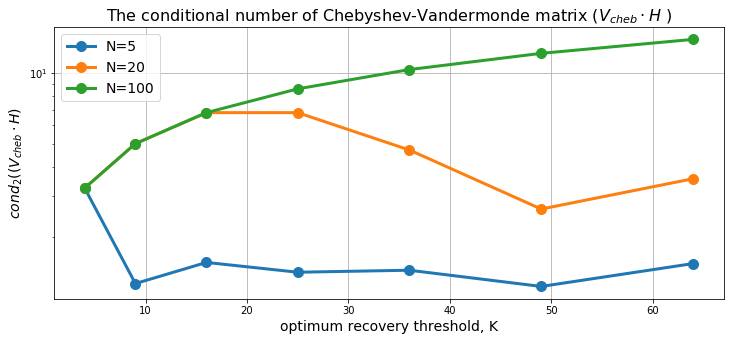

In [17]:
plt.figure(figsize=((12, 5)))
plt.grid() 

for N in Ns:
    plt.plot(rec_thr**2, cond_cheb_vander[N],  marker='o', lw=3, markersize=10, label=f'N={N}')

plt.xlabel("optimum recovery threshold, K", fontsize=14)
plt.ylabel("$cond_2((V_{cheb} \cdot H)$", fontsize=14)
plt.yscale("log")
#plt.xscale('log')
plt.title("The conditional number of Chebyshev-Vandermonde matrix $(V_{cheb} \cdot H$ )", fontsize=16)
plt.legend(loc='best', fontsize=14)
# plt.savefig("graph_cond_of_vander")

## RKKP codes

In [18]:
# !pip install scipy==1.6.1

In [19]:
# import scipy
# print(scipy.__version__)

In [20]:
from scipy.linalg import khatri_rao

In [21]:
def encode_RKKP_matrix(matrix_parts, N, seed=None):
    parts = len(matrix_parts)

    np.random.seed(seed)
    R = np.random.rand(N, parts)

    matrix_tilda = [sum(matrix_parts[j] * r[j]  for j in range(parts)) for r in R]

    return matrix_tilda, R


def recovery_matrix_RKKP(C_tilda, saved_nodes, P, Q, l, p):
    (N, m), n = P.shape, Q.shape[1]

    G = khatri_rao(P.T, Q.T).T
    G_pinv = np.linalg.pinv(G[saved_nodes])

    C_tilda_reshaped = C_tilda.reshape(len(saved_nodes), -1)
    
    C_rec_reshaped = G_pinv @ C_tilda_reshaped

    C_rec_reshaped = np.vstack([C_i.reshape(l, p) for C_i in C_rec_reshaped])

    C_rec = np.hstack(np.split(C_rec_reshaped, m*n))
    C_rec = np.vstack(np.split(C_rec, m, 1))

    return C_rec

In [22]:
m, n = 4, 3
bound = 10

N = 12
K = m * n

#Input matrix size - A: s by r, B: s by t
s = 4
r = 12
t = 12
l = r // m
p = t // n

In [23]:
straglers = 0

A = np.random.randint(1, 10, (s, r))
B = np.random.randint(1, 10, (s, t))
C = A.T @ B

A_parts = split_matrix(A, m)
B_parts = split_matrix(B, n)

A_tilda, P = encode_RKKP_matrix(A_parts, N)
B_tilda, Q = encode_RKKP_matrix(B_parts, N)

A_tilda, B_tilda, saved_nodes = stragle_random_part(A_tilda, B_tilda, straglers, seed=None)


C_tilda = [A_ti.T @ B_ti for A_ti, B_ti in zip(A_tilda, B_tilda)]
C_tilda = np.vstack(C_tilda)

C_rec = recovery_matrix_RKKP(C_tilda, saved_nodes, P, Q, l, p)

In [24]:
#print(C, C_rec, sep='\n\n')

nmse = np.linalg.norm(abs(C - C_rec)) / np.linalg.norm(C)
print("NMSE:", nmse)

NMSE: 7.787201391976645e-15


In [41]:
def RKKP_experiment(m, n, N, A, B, r, t, straglers=0, verbose=False):
    A = np.random.rand(s, r)
    B = np.random.rand(s, t)
    C = A.T @ B
    
    x = np.arange(1, N + 1)
    x = np.cos((2*x - 1) * np.pi / 2 / N)

    if verbose:
        print('A, B, C:', end='\n\n')
        print(A, B, C, sep='\n\n')

    A_parts = split_matrix(A, m)
    B_parts = split_matrix(B, n)
    
    l, p = r // m, t // n

    A_tilda, P = encode_RKKP_matrix(A_parts, N)
    B_tilda, Q = encode_RKKP_matrix(B_parts, N)

    A_tilda, B_tilda, saved_nodes = stragle_random_part(A_tilda, B_tilda, straglers, seed=RANDOM_STATE)

    C_tilda = [A_ti.T @ B_ti for A_ti, B_ti in zip(A_tilda, B_tilda)]
    C_tilda = np.vstack(C_tilda)

    C_rec = recovery_matrix_RKKP(C_tilda, saved_nodes, P, Q, l, p)

    if verbose:
        print('\nC_rec, C:', end='\n\n')
        print(C_rec, C, sep='\n\n')

    nmse = np.linalg.norm(abs(C - C_rec))/np.linalg.norm(C)
    return nmse

In [31]:
print('NMSE:', RKKP_experiment(7, 7, 50, 49 * 4, 49 * 4, straglers=2, verbose=False))

NMSE: 0.02304171079742125


In [33]:
def calculate_cond_RKKP(N, grid):
    cond_RKKP = []
    
    for m in grid:
        P = np.random.rand(m, N)
        Q = np.random.rand(m, N)
        G = khatri_rao(P, Q).T

        cond_RKKP.append(np.linalg.cond(G))

    return cond_RKKP

Ns = [5, 20, 100]
rec_thr = np.arange(2, 10)
cond_RKKP = {n: calculate_cond_RKKP(n, rec_thr) for n in Ns}

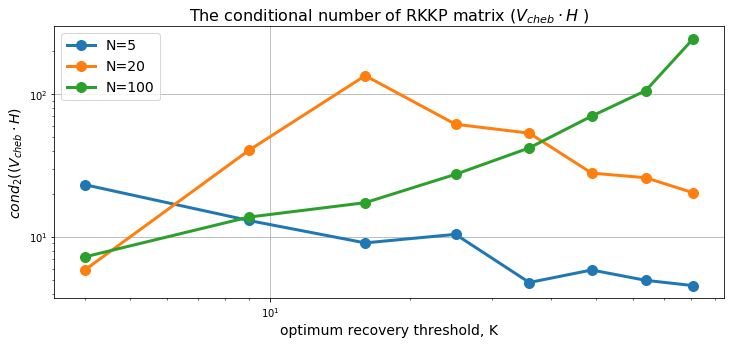

In [34]:
plt.figure(figsize=((12, 5)))
plt.grid() 

for N in Ns:
    plt.plot(rec_thr**2, cond_RKKP[N], marker='o', lw=3, markersize=10, label=f'N={N}')

plt.xlabel("optimum recovery threshold, K", fontsize=14)
plt.ylabel("$cond_2((V_{cheb} \cdot H)$", fontsize=14)
plt.yscale("log")
plt.xscale('log')
plt.title("The conditional number of RKKP matrix $(V_{cheb} \cdot H$ )", fontsize=16)
plt.legend(loc='best', fontsize=14)
# plt.savefig("graph_cond_of_vander")

In [35]:
rec_thr = np.arange(2, 107, 7)
rec_thr_sqt = np.arange(2, 11)
Ns = [5, 20, 100]

cond_vander = {n: calculate_cond_vander(n, rec_thr) for n in Ns}
cond_cheb_vander = {n: calculate_cond_cheb_vander(n, rec_thr_sqt) for n in Ns} 
cond_RKKP = {n: calculate_cond_RKKP(n, rec_thr_sqt) for n in Ns}

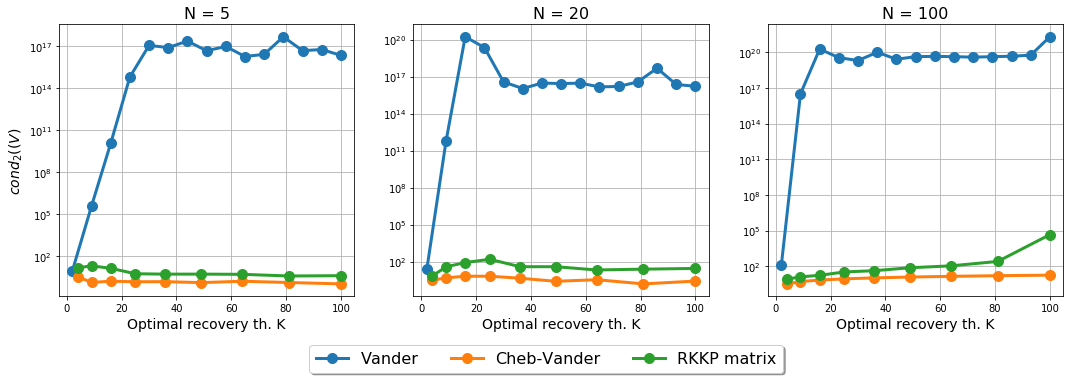

In [36]:
fig, axis = plt.subplots(1, len(Ns), figsize=(18, 5))

for ax, n in zip(axis, Ns):
    ax.plot(rec_thr, cond_vander[n], marker='o', lw=3, markersize=10, label='Vander')
    ax.plot(rec_thr_sqt**2, cond_cheb_vander[n], marker='o', lw=3, markersize=10, label='Cheb-Vander')
    ax.plot(rec_thr_sqt**2, cond_RKKP[n], marker='o', lw=3, markersize=10, label='RKKP matrix')
    
    ax.set_xlabel('Optimal recovery th. K', fontsize=14)
    ax.set_yscale('log')
    ax.set_title(f'N = {n}', fontsize=16)
    ax.grid()

axis[0].set_ylabel("$cond_2((V)$", fontsize=14)
ax.legend(loc='upper center', bbox_to_anchor=(-0.75, -0.15),
              fancybox=True, shadow=True, ncol=3, fontsize=16)

In [42]:
def calculate_nmse(m, n, n_straglers, s, r, t):
    A = np.random.rand(s, r)
    B = np.random.rand(s, t)
    
    poly_nmse = [poly_experiment(m, n, ns + m*n, A, B, r, t, straglers=ns, verbose=False) 
                 for ns in n_straglers]  
    orthopoly_nmse = [orthopoly_experiment(m, n, ns + m*n, A, B, r, t, straglers=ns, verbose=False) 
                      for ns in n_straglers]
    rkkp_nmse = [RKKP_experiment(m, n, ns + m*n, A, B, r, t, straglers=ns, verbose=False) 
                 for ns in n_straglers] 

    return np.array(poly_nmse), np.array(orthopoly_nmse), np.array(rkkp_nmse)


n_straglers = np.arange(0, 31)
nmses = np.array([calculate_nmse(7, 7, n_straglers, 21, 49 * 4, 49 * 4) for _ in range(100)]).mean(axis=0)

In [43]:
poly_nmse = nmses[0]
orthopoly_nmse = nmses[1]
rkkp_nmse = nmses[2]

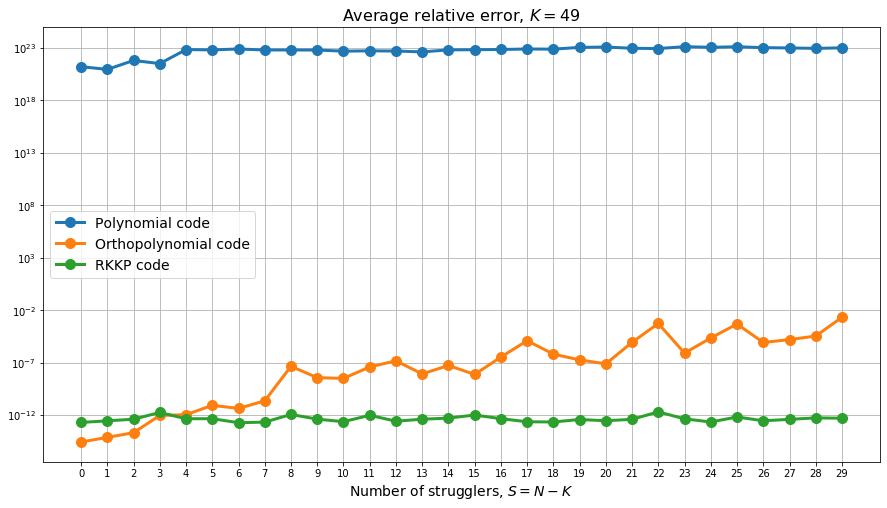

In [44]:
K = 49

plt.figure(figsize=((15, 8)))
plt.grid() 

end = 30

plt.plot(n_straglers[:end], poly_nmse[:end], marker='o', lw=3, markersize=10, label=f'Polynomial code')
plt.plot(n_straglers[:end], orthopoly_nmse[:end], marker='o', lw=3, markersize=10, label=f'Orthopolynomial code')
plt.plot(n_straglers[:end], rkkp_nmse[:end], marker='o', lw=3, markersize=10, label=f'RKKP code')
plt.xlabel("Number of strugglers, $S=N-K$", fontsize=14)
# plt.ylabel("", fontsize=14)
plt.yscale("log")
plt.title(f"Average relative error, $K = {K}$", fontsize=16)
plt.legend(loc='center left', fontsize=14)
plt.xticks(n_straglers[:end])

# plt.savefig("graph_average_relative_error")

plt.show()